In [2]:
# Cell 1: Imports & display settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter
from wordcloud import WordCloud

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Scikit-learn helpers (for later modeling steps)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')


In [3]:
# Cell 2: NLTK downloads (run once in the environment)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to C:\Users\Brindha Suvarna
[nltk_data]     R\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to C:\Users\Brindha Suvarna
[nltk_data]     R\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to C:\Users\Brindha Suvarna
[nltk_data]     R\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to C:\Users\Brindha Suvarna
[nltk_data]     R\AppData\Roaming\nltk_data...


True

In [9]:
# Cell 3: Robust dataset loading with correct relative path
import os
import pandas as pd

# Correct relative path from notebooks folder
file_path = '../data/raw/review.csv'

# Check current working directory
print("Current working directory:", os.getcwd())

# Check if file exists
if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully!")
    print("Shape:", df.shape)
    display(df.head(10))
else:
    print(f"Error: File not found at '{file_path}'.")
    print("Files in '../data/raw' folder:", os.listdir('../data/raw') if os.path.exists('../data/raw') else "Folder does not exist")


Current working directory: c:\Users\Brindha Suvarna R\Desktop\sentiment-classifier\notebooks
Dataset loaded successfully!
Shape: (8236, 3)


,review,model,sentiment
0,The movie was a complete snoozefest. I regret...,Gemini-1.5-Flash,negative
1,"Seriously, the worst venue I've ever been to. ...",Gemini-1.5-Flash,negative
2,"This event was so poorly organized, it was a j...",Gemini-1.5-Flash,negative
3,What a disaster of a movie! The acting was aw...,Gemini-1.5-Flash,negative
4,I wouldn't recommend this venue to my worst en...,Gemini-1.5-Flash,negative
5,The event was a complete letdown. The perform...,Gemini-1.5-Flash,negative
6,This movie was boring and predictable. I could...,Gemini-1.5-Flash,negative
7,The sound system at the venue was atrocious. I...,Gemini-1.5-Flash,negative
8,The event was poorly advertised and even worse...,Gemini-1.5-Flash,negative
9,This movie had a terrible plot and unbelievabl...,Gemini-1.5-Flash,negative


In [10]:
# Cell 4: Info, missing values, duplicates
df.info()
print("\nMissing values per column:\n", df.isnull().sum())
print("\nNumber of duplicate rows:", df.duplicated().sum())

# If your text column or label column have different names, note them here:
# Example: text column named 'review' and label column named 'sentiment'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8236 entries, 0 to 8235
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     8236 non-null   object
 1   model      8234 non-null   object
 2   sentiment  8234 non-null   object
dtypes: object(3)
memory usage: 193.2+ KB

Missing values per column:
 review       0
model        2
sentiment    2
dtype: int64

Number of duplicate rows: 2555


In [11]:
# Cell 5 — Identify text and label columns (correct for your dataset)
TEXT_COL = 'review'
LABEL_COL = 'sentiment'

print("Columns in dataset:", df.columns.tolist())
assert TEXT_COL in df.columns, f"'{TEXT_COL}' column not found!"
assert LABEL_COL in df.columns, f"'{LABEL_COL}' column not found!"
print("Text column:", TEXT_COL)
print("Label column:", LABEL_COL)


Columns in dataset: ['review', 'model', 'sentiment']
Text column: review
Label column: sentiment


Label counts:
 sentiment
positive    3110
negative    2663
neutral     2461
NaN            2
Name: count, dtype: int64


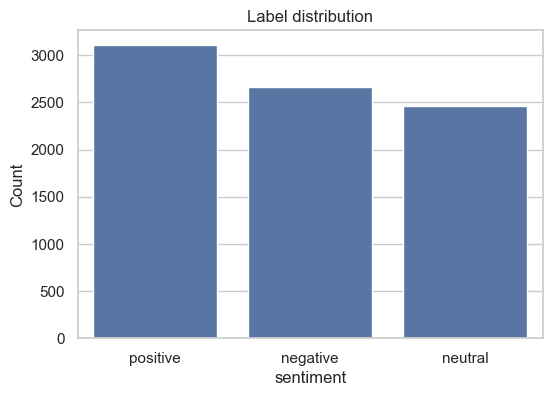

In [12]:
# Cell 6: Label distribution
label_counts = df[LABEL_COL].value_counts(dropna=False)
print("Label counts:\n", label_counts)
plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Label distribution')
plt.ylabel('Count')
plt.xlabel(LABEL_COL)
plt.show()


,review,text_len_chars,text_len_words,sentiment
0,The movie was a complete snoozefest. I regret...,86,14,negative
1,"Seriously, the worst venue I've ever been to. ...",115,19,negative
2,"This event was so poorly organized, it was a j...",85,16,negative
3,What a disaster of a movie! The acting was aw...,113,20,negative
4,I wouldn't recommend this venue to my worst en...,90,15,negative


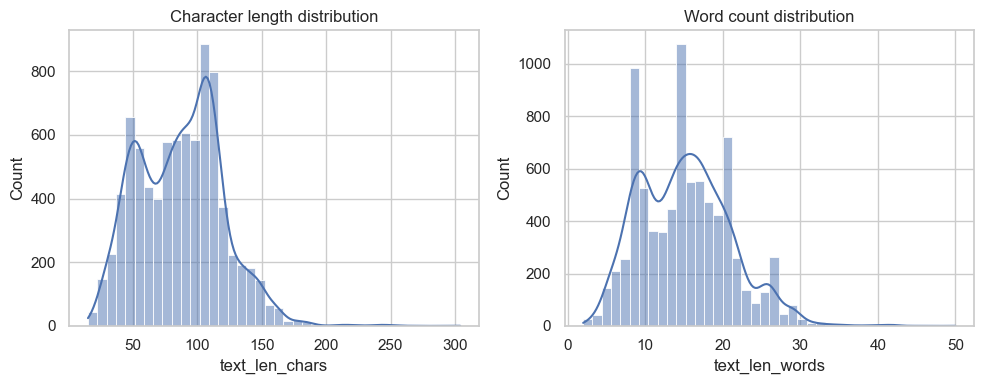

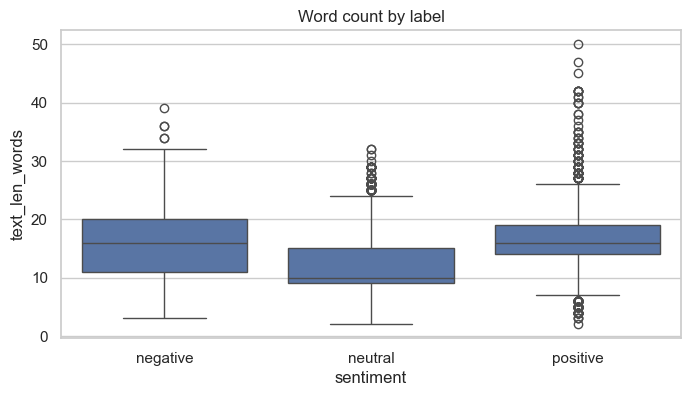

In [13]:
# Cell 7: Text length features
df['text_len_chars'] = df[TEXT_COL].astype(str).apply(len)
df['text_len_words'] = df[TEXT_COL].astype(str).apply(lambda x: len(x.split()))

display(df[[TEXT_COL, 'text_len_chars', 'text_len_words', LABEL_COL]].head())

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(df['text_len_chars'], bins=40, kde=True)
plt.title('Character length distribution')

plt.subplot(1,2,2)
sns.histplot(df['text_len_words'], bins=40, kde=True)
plt.title('Word count distribution')
plt.tight_layout()
plt.show()

# Boxplot per label (helps see outliers / very long reviews)
plt.figure(figsize=(8,4))
sns.boxplot(x=LABEL_COL, y='text_len_words', data=df)
plt.title('Word count by label')
plt.show()


In [3]:
# Cell 8: Load dataset + Text cleaning & preprocessing helper
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# === 1. Load your dataset ===
df = pd.read_csv("../data/raw/review.csv")   # <-- fixed path
print("Dataset loaded successfully!")
print(df.head())

# === 2. Download required NLTK resources ===
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# === 3. Define stopwords and lemmatizer ===
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# === 4. Specify your text column ===
TEXT_COL = 'review'  # change if your CSV uses a different column name

# === 5. Define cleaning function ===
def clean_text(text, remove_stopwords=True, do_lemmatize=True):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = nltk.word_tokenize(text)
    if remove_stopwords:
        tokens = [t for t in tokens if t not in stop_words]
    if do_lemmatize:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

# === 6. Test cleaning on sample ===
print("\nSample cleaning output:\n")
sample = df[TEXT_COL].astype(str).iloc[:5]
for s in sample:
    print("ORIG:", s)
    print("CLEAN:", clean_text(s))
    print("---")


Dataset loaded successfully!
                                              review             model  \
0  The movie was a complete snoozefest.  I regret...  Gemini-1.5-Flash   
1  Seriously, the worst venue I've ever been to. ...  Gemini-1.5-Flash   
2  This event was so poorly organized, it was a j...  Gemini-1.5-Flash   
3  What a disaster of a movie!  The acting was aw...  Gemini-1.5-Flash   
4  I wouldn't recommend this venue to my worst en...  Gemini-1.5-Flash   

  sentiment  
0  negative  
1  negative  
2  negative  
3  negative  
4  negative  

Sample cleaning output:

ORIG: The movie was a complete snoozefest.  I regretted every second.  Total waste of money.


[nltk_data] Downloading package punkt to C:\Users\Brindha Suvarna
[nltk_data]     R\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Brindha Suvarna
[nltk_data]     R\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Brindha Suvarna
[nltk_data]     R\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Brindha Suvarna
[nltk_data]     R\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


CLEAN: movie complete snoozefest regretted every second total waste money
---
ORIG: Seriously, the worst venue I've ever been to.  The sound was terrible, the seats uncomfortable, and the staff rude.
CLEAN: seriously worst venue ever sound terrible seat uncomfortable staff rude
---
ORIG: This event was so poorly organized, it was a joke.  I left early, feeling ripped off.
CLEAN: event poorly organized joke left early feeling ripped
---
ORIG: What a disaster of a movie!  The acting was awful, the plot was nonsensical, and the special effects were cheesy.
CLEAN: disaster movie acting awful plot nonsensical special effect cheesy
---
ORIG: I wouldn't recommend this venue to my worst enemy.  It was dirty, cramped, and overpriced.
CLEAN: recommend venue worst enemy dirty cramped overpriced
---


In [4]:
# Cell 9: Create cleaned text column (this may take time for huge datasets)
df['clean_text'] = df[TEXT_COL].astype(str).apply(clean_text)
display(df[[TEXT_COL, 'clean_text']].head())


,review,clean_text
0,The movie was a complete snoozefest. I regret...,movie complete snoozefest regretted every seco...
1,"Seriously, the worst venue I've ever been to. ...",seriously worst venue ever sound terrible seat...
2,"This event was so poorly organized, it was a j...",event poorly organized joke left early feeling...
3,What a disaster of a movie! The acting was aw...,disaster movie acting awful plot nonsensical s...
4,I wouldn't recommend this venue to my worst en...,recommend venue worst enemy dirty cramped over...


In [6]:
# Cell 10: Top words overall and per label
from collections import Counter

# Make sure you have a 'clean_text' column
if 'clean_text' not in df.columns:
    print("🟡 'clean_text' not found — generating it now...")
    df['clean_text'] = df['review'].apply(clean_text)

# Define your label column name (update if needed)
LABEL_COL = 'label'  # <-- change to your actual label column name

def get_top_n_words(corpus, n=25):
    words = " ".join(corpus).split()
    return Counter(words).most_common(n)

# === Overall top words ===
top_overall = get_top_n_words(df['clean_text'].dropna(), 30)
print("Top overall words:")
print(top_overall[:15])

# === Top words per label ===
if LABEL_COL in df.columns:
    for lbl in df[LABEL_COL].unique():
        texts = df.loc[df[LABEL_COL] == lbl, 'clean_text'].dropna()
        top = get_top_n_words(texts, 20)
        print(f"\nTop words for label = {lbl}:")
        print(top[:15])
else:
    print(f"⚠️ Column '{LABEL_COL}' not found in dataset. Please check your label column name.")


Top overall words:
[('new', 907), ('product', 668), ('event', 628), ('movie', 546), ('service', 461), ('store', 450), ('great', 437), ('ad', 421), ('restaurant', 411), ('spa', 411), ('staff', 404), ('food', 400), ('time', 392), ('toy', 392), ('okay', 387)]
⚠️ Column 'label' not found in dataset. Please check your label column name.


In [10]:
from sklearn.feature_extraction.text import CountVectorizer

def top_ngrams(corpus, ngram_range=(2,2), n=None):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vectorizer.fit_transform(corpus)
    sums = X.sum(axis=0)
    data = [(word, sums[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    data = sorted(data, key=lambda x: x[1], reverse=True)
    return data[:n]

print("Top bigrams overall:", top_ngrams(df['clean_text'].astype(str), ngram_range=(2,2), n=20))
print("Top trigrams overall:", top_ngrams(df['clean_text'].astype(str), ngram_range=(3,3), n=20))


Top bigrams overall: [('highly recommend', np.int64(205)), ('service slow', np.int64(162)), ('brand product', np.int64(143)), ('got amazing', np.int64(140)), ('amazing new', np.int64(139)), ('waste money', np.int64(134)), ('customer service', np.int64(131)), ('complete waste', np.int64(128)), ('waste time', np.int64(120)), ('tried new', np.int64(118)), ('bought new', np.int64(112)), ('event complete', np.int64(97)), ('special effect', np.int64(95)), ('staff unhelpful', np.int64(91)), ('bought toy', np.int64(91)), ('new toy', np.int64(91)), ('going love', np.int64(89)), ('total letdown', np.int64(88)), ('new restaurant', np.int64(81)), ('pretty standard', np.int64(78))]
Top trigrams overall: [('got amazing new', np.int64(138)), ('complete waste time', np.int64(67)), ('ad pretty standard', np.int64(62)), ('standard product shown', np.int64(62)), ('pretty standard product', np.int64(61)), ('store alright price', np.int64(60)), ('new ad campaign', np.int64(60)), ('alright price okay', np.i

In [13]:
# Cell 13: TF-IDF vectorization quick check
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# TF-IDF vectorization quick check
tfv = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_tfidf = tfv.fit_transform(df['clean_text'].astype(str))
print("TF-IDF matrix shape:", X_tfidf.shape)

# Show top features by average TF-IDF
avg_tfidf = np.asarray(X_tfidf.mean(axis=0)).ravel()
top_n = 20
top_idx = avg_tfidf.argsort()[-top_n:][::-1]
top_features = [tfv.get_feature_names_out()[i] for i in top_idx]
print("Top TF-IDF features:", top_features)



TF-IDF matrix shape: (8236, 5000)
Top TF-IDF features: ['product', 'event', 'new', 'movie', 'okay', 'great', 'service', 'good', 'store', 'spa', 'toy', 'bit', 'ad', 'venue', 'food', 'time', 'brand', 'complete', 'restaurant', 'staff']


✅ Cleaned dataset saved successfully at: data/processed/cleaned_reviews.csv
Rows: 8236
Columns: ['review', 'model', 'sentiment', 'clean_text']


In [16]:
# Cell 14 — Save cleaned file for modeling (absolute path)
import os

# Absolute path to processed folder
processed_folder = r"C:\Users\Brindha Suvarna R\Desktop\sentiment-classifier\data\processed"
os.makedirs(processed_folder, exist_ok=True)  # create folder if it doesn't exist

# Define output file path
output_path = os.path.join(processed_folder, "cleaned_reviews.csv")

# Save cleaned dataframe
df.to_csv(output_path, index=False)

print(f"✅ Cleaned dataset saved successfully at: {output_path}")
print("Rows:", len(df))
print("Columns:", df.columns.tolist())


✅ Cleaned dataset saved successfully at: C:\Users\Brindha Suvarna R\Desktop\sentiment-classifier\data\processed\cleaned_reviews.csv
Rows: 8236
Columns: ['review', 'model', 'sentiment', 'clean_text']
